<a href="https://www.kaggle.com/code/aayusmaanjain/license-plate-detection?scriptVersionId=101824514" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Dependencies

In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import os 
import shutil
from tqdm import tqdm
import yaml
import matplotlib.pyplot as plt 
import torch
import cv2
import pytesseract as pt 
%matplotlib inline

In [2]:
filenames = []

size_props = {
    'height':[],
    'width':[]
}

bounding_box_props = {
    'xmin':[],
    'ymin':[],
    'xmax':[],
    'ymax':[]
}

# Fetching required properties from annotations

In [3]:
annotations_path = '../input/car-plate-detection/annotations'
for file in tqdm(os.listdir(annotations_path)):
    annotation = ET.parse(os.path.join(annotations_path, file))
    filenames.append(os.path.join(annotations_path, file))
    size = annotation.find('size')
    for name, prop_list in size_props.items():
        prop_value = size.find(name).text
        size_props[name].append(int(prop_value))
    bounding_box = annotation.find('object').find('bndbox')
    for name, prop_list in bounding_box_props.items():
        prop_value = bounding_box.find(name).text
        bounding_box_props[name].append(int(prop_value))

100%|██████████| 433/433 [00:01<00:00, 320.84it/s]


In [4]:
df = pd.DataFrame({
    'file':filenames,
    'width':size_props['width'],
    'height':size_props['height'],
    'xmin':bounding_box_props['xmin'],
    'ymin':bounding_box_props['ymin'],
    'xmax':bounding_box_props['xmax'],
    'ymax':bounding_box_props['ymax']
})

In [5]:
df.head()

,file,width,height,xmin,ymin,xmax,ymax
0,../input/car-plate-detection/annotations/Cars3...,500,300,209,135,283,169
1,../input/car-plate-detection/annotations/Cars1...,400,268,191,147,242,169
2,../input/car-plate-detection/annotations/Cars7...,400,267,115,115,277,153
3,../input/car-plate-detection/annotations/Cars1...,400,221,36,175,62,186
4,../input/car-plate-detection/annotations/Cars2...,517,303,71,205,215,246


# Making annotations compatible with YOLO

In [6]:
df['center_x'] = (df['xmax'] + df['xmin'])/(2*df['width'])
df['center_y'] = (df['ymax'] + df['ymin'])/(2*df['height'])

df['bb_width'] = (df['xmax'] - df['xmin'])/df['width']
df['bb_height'] = (df['ymax'] - df['ymin'])/df['height']

In [7]:
df.head()

,file,width,height,xmin,ymin,xmax,ymax,center_x,center_y,bb_width,bb_height
0,../input/car-plate-detection/annotations/Cars3...,500,300,209,135,283,169,0.492000,0.506667,0.14800,0.113333
1,../input/car-plate-detection/annotations/Cars1...,400,268,191,147,242,169,0.541250,0.589552,0.12750,0.082090
2,../input/car-plate-detection/annotations/Cars7...,400,267,115,115,277,153,0.490000,0.501873,0.40500,0.142322
3,../input/car-plate-detection/annotations/Cars1...,400,221,36,175,62,186,0.122500,0.816742,0.06500,0.049774
4,../input/car-plate-detection/annotations/Cars2...,517,303,71,205,215,246,0.276596,0.744224,0.27853,0.135314


In [8]:
# Keeping important columns only 
yolo_df = df[['file', 'center_x', 'center_y', 'bb_width', 'bb_height']]
# Performing 70-15-15 split
test_size = int(0.15 * len(df))

df_train, df_test = train_test_split(yolo_df, test_size=test_size)
df_train, df_val = train_test_split(df_train, test_size=test_size)

In [9]:
train_path = os.path.join('Images', 'train')
val_path = os.path.join('Images','val')
test_path = os.path.join('Images', 'test')
images_path = '../input/car-plate-detection/images'

if not os.path.exists(train_path):
    os.makedirs(train_path)
    print('Made folder for train set')

if not os.path.exists(val_path):
    os.makedirs(val_path)
    print('Made folder for val set')

if not os.path.exists(test_path):
    os.makedirs(test_path)
    print('Made folder for test set')

Made folder for train set
Made folder for val set
Made folder for test set


# Creating train and test folders 

In [10]:
print('Moving images for train set')
for _, row  in tqdm(df_train.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(train_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(train_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for train set')

print('Moving images for val set')
for _, row  in tqdm(df_val.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(val_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(val_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for val set')

print('Moving images for test set')
for _, row  in tqdm(df_test.iterrows()):
    annotation_path = row['file']
    image_name = os.path.split(annotation_path)[-1].replace('.xml','')
    image_src = os.path.join(images_path, f'{image_name}.png')
    image_dst = os.path.join(test_path, f'{image_name}.png')
    shutil.copy2(image_src, image_dst)
    label_text = f"0 {row['center_x']} {row['center_y']} {row['bb_width']} {row['bb_height']}"
    with open(os.path.join(test_path, f'{image_name}.txt'), 'w') as f:
        f.write(label_text)
print('Done moving images for test set')

Moving images for train set


305it [00:04, 65.38it/s]


Done moving images for train set
Moving images for val set


64it [00:00, 75.79it/s]


Done moving images for val set
Moving images for test set


64it [00:00, 81.67it/s]

Done moving images for test set


# Training YOLO model

In [11]:
# Cloning the ultralytics yolo repository
! git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 13151, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 13151 (delta 13), reused 13 (delta 5), pack-reused 13122
Receiving objects: 100% (13151/13151), 12.54 MiB | 15.76 MiB/s, done.
Resolving deltas: 100% (9026/9026), done.


In [12]:
# Installing the dependencies required for YOLO
! pip install -r yolov5/requirements.txt

In [13]:
# creating data.yaml file which will be used to train YOLO on custom data 
data = {
    'names':['License Plate'],
    'nc':1,
    'train':os.path.abspath(train_path),
    'val':os.path.abspath(val_path)
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

In [14]:
# Training the YOLO model 
! python ./yolov5/train.py --data ./data.yaml  --batch-size 8  --epochs 100 --weights yolov5/yolov5s.pt

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5/yolov5s.pt, cfg=, data=./data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (Docker image), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 v6.1-324-g0b5ac22 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperp

# Loading best model 

In [15]:
# Fetching the latest runs
yolo_path = '/kaggle/working/yolov5/runs/train/'
latest_run = os.listdir(yolo_path)[-1]

# Fetching the best weights 
best_weights = os.path.join(yolo_path, latest_run, 'weights', 'best.pt')

# Loading the model with best weights trained on custom data 
model = torch.hub.load('ultralytics/yolov5', 'custom', best_weights)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2022-7-26 Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


# Visualizing predictions

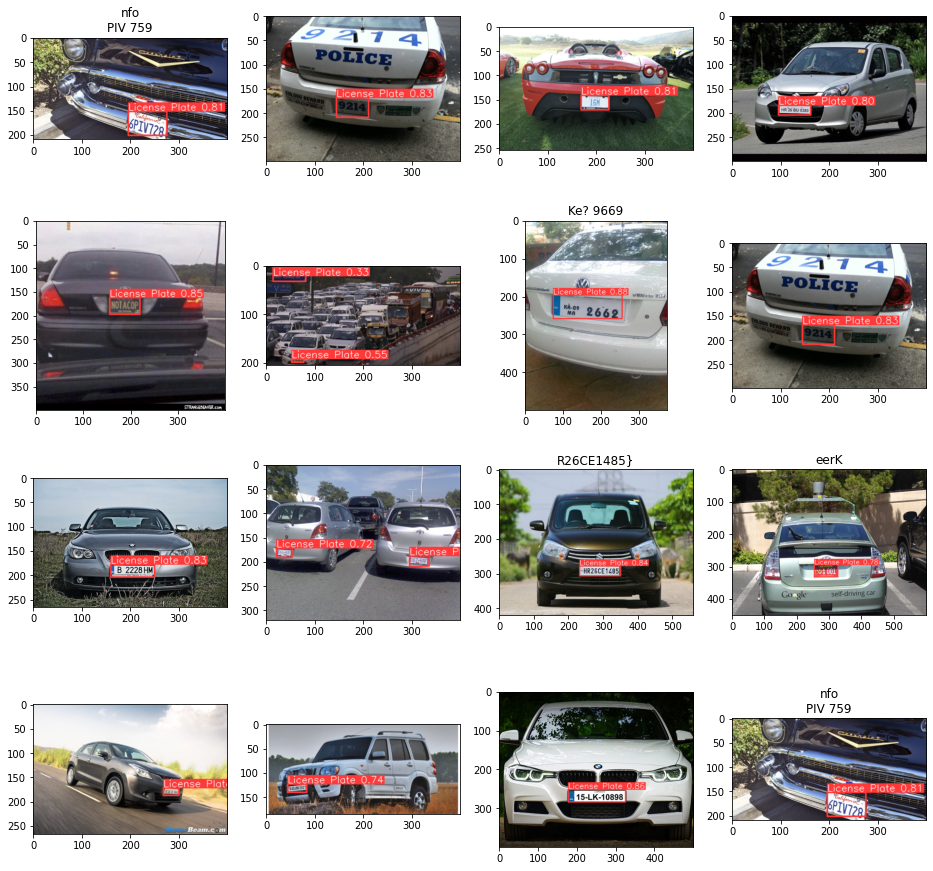

In [16]:
%matplotlib inline
# Fetching random 16 images from test set
test_files = df_test['file'].apply(lambda x: x.replace('annotations','images').replace('xml','png'))
test_images = np.random.choice(test_files, size=(4,4))

# Visualizing predictions
fig, ax = plt.subplots(figsize=(16,16), nrows=4, ncols=4)
for i in range(4):
    for j in range(4):
        # Reading the image 
        image = cv2.imread(test_images[i,j])
        # Convert image to RGB colorspace
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Predicting from model
        results = model(image)
        # Getting co ordinates of license plate
        results_df = results.pandas().xyxy[0].loc[0]
        x_min = int(results_df['xmin'])
        x_max = int(results_df['xmax'])
        y_min = int(results_df['ymin'])
        y_max = int(results_df['ymax'])
        # Cropping license plate from image ""
        number_plate = image[y_min:y_max,x_min:x_max]
        # Performing OCR on image 
        text = pt.image_to_string(number_plate)
        # Showing the results 
        ax[i,j].set_title(str(text).strip())
        ax[i,j].imshow(np.squeeze(results.render()))
plt.show()

I have created a repository on github which uses the model trained in this notebook to perform real time license plate detection, then read the license plate numbers using OCR and then make an entry in a database along with the timestamp when the license plate was detected. 

In this way, we will be able to keep a track of unknown vehicles in the society which may cause inconvinience to the society members.

I have also created a web UI where the society residents can register themselves and their vehicles 

<a href="https://github.com/aayush1036/residential-safety-solution">Github project</a>

Please star and fork the repository if you like the project